# 1 Environment
- Python version: 3.11.7  
- OS: Windows 11  
- Environment: Visual Studio Code

### Packages
- pandas
- .. zu erweitern, eventuell Requirements.txt

# 2 Load Data 
Load Data describe in detail their origin, content, structures and data types.

In [23]:
import pandas as pd
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")
print(df.describe(include='all'))
y = df['quality']


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

### wine quality (Duc)

origin= archive.ics.uci.edu

        - UC Irvine, Maschine Learning Repository
        - has 683 datasets currently

content = 
- data length is 1599 = count
- 12 kinds of features:  
    - fixed acidity :  
            - min   4.60  
            - max   15.9  
            - mean  8.3  
            - std   1.7  
            -> huge differenz, but that might be an exception  
            -> mostly around 8.3 with 1.7 deviation : 7-10  
    - volatile acidity :  
            - min   0.12  
            - max   1.58  
            - mean  0.527 ~ 0.53  
            - std   0.179 ~ 0.18  
    - citric acid :  
            - min   0.0  
            - max   1.0  
            - mean  0.27  
            - std   0.19  
    - residual sugar:  
            - min   0.9  
            - max   15.5  
            - mean  2.538 ~ 2.54  
            - std   1.40  
              
  several features/themes related to the wine: chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality  
- all have these subfeatures: count, mean, std, min, 25%,50%,75%,max
- categories focus on wine content, what its made of
structures = 
    - 3x4 columns
    - the subfeatures on the left side 
    - maybe categorized? 

data types =  only float numbers can be seen, except 1 int.



# 3  Data Exploration
Prepare statistical and visual data summaries.  

How many variables/features does the data contain, how many samples? Are there missing values? Explore correlations among variables and conduct at least one unsupervised analysis. Consider variable transformations and normalizations where applicable.


In [24]:
print("Missing Values in each column:")
print(df.isna().sum())
# 12 features/variables 
# no missing values
# all numerical, all float, 1 int (quality)
# 1599 samples/rows
(print("Statistical Summary:"))
print(df.info())
print(df.shape)

#Correlation neutral, positive, negative: df.corr()
#one unsupervised analysis
#variable transformations and normalizations where capable

Missing Values in each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Statistical Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   p

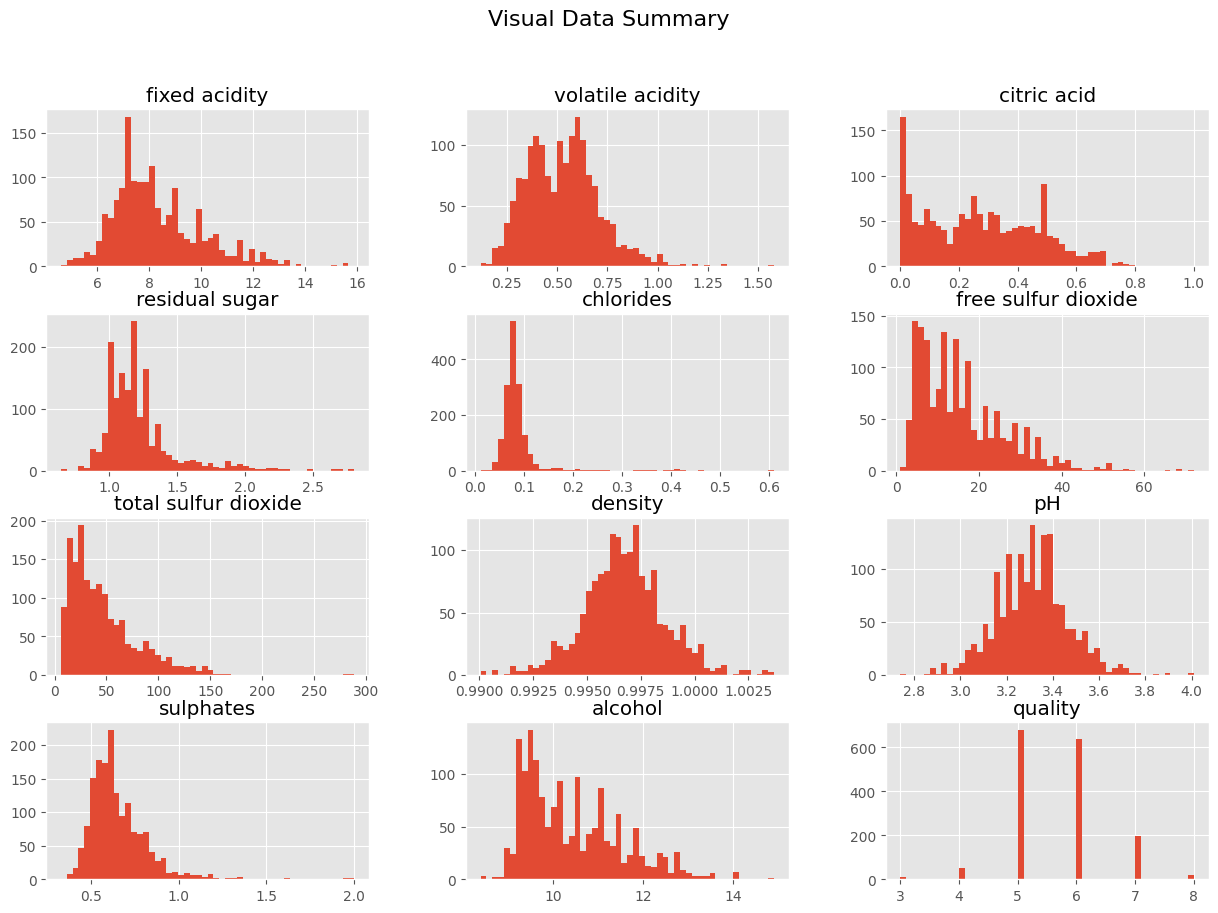

In [ ]:
import matplotlib.pyplot as plt

df.hist(figsize=(15,10), bins=50) #bins anpassen
plt.suptitle("Visual Data Summary", fontsize=16)
plt.show()
#Motivation: see distributions of features individually -> clear to see skewness, outliers, normality, less chaos

#none equally distributed
#some skewed right: residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide
#some approx normal: fixed acidity, citric acid, pH, sulphates, alcohol
#some approx uniform: volatile acidity, density 

In [ ]:
#normalization
from sklearn.preprocessing import StandardScaler

features = ["fixed acidity", "volatile acidity", "citric acid", 
            "residual sugar", "chlorides", "free sulfur dioxide",
            "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)

df_scaled.hist(figsize=(15,10), bins=50, color='skyblue', edgecolor='black')
plt.suptitle("Visual Data Summary (Scaled Features)", fontsize=16)
plt.show()

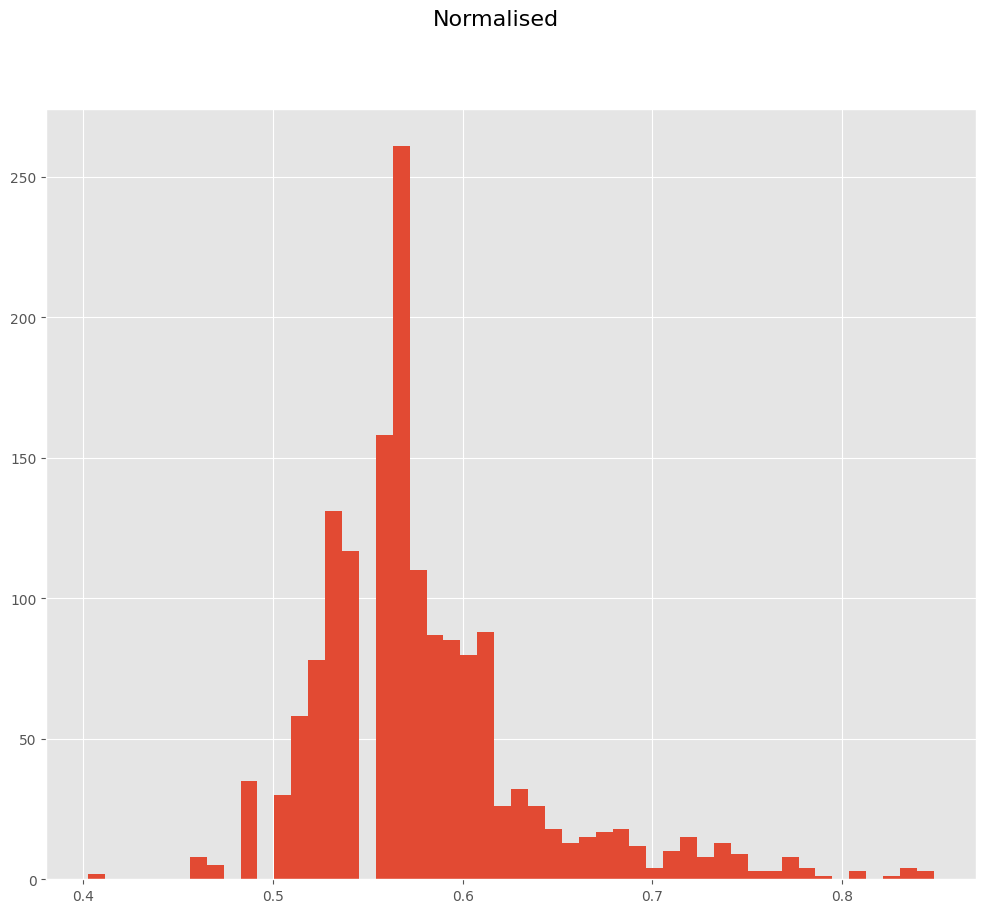

In [ ]:
import numpy as np


df['residual sugar'] = np.log1p(df['residual sugar'])
df["residual sugar"].hist(figsize=(12,10),bins=50)
plt.suptitle("Normalised", fontsize=16)
plt.show()

#log transformation to reduce skewness of residual sugar
#makes it more evenly distributed 
#more beautiful

### Korrelationen aller Features miteinander (Duc)

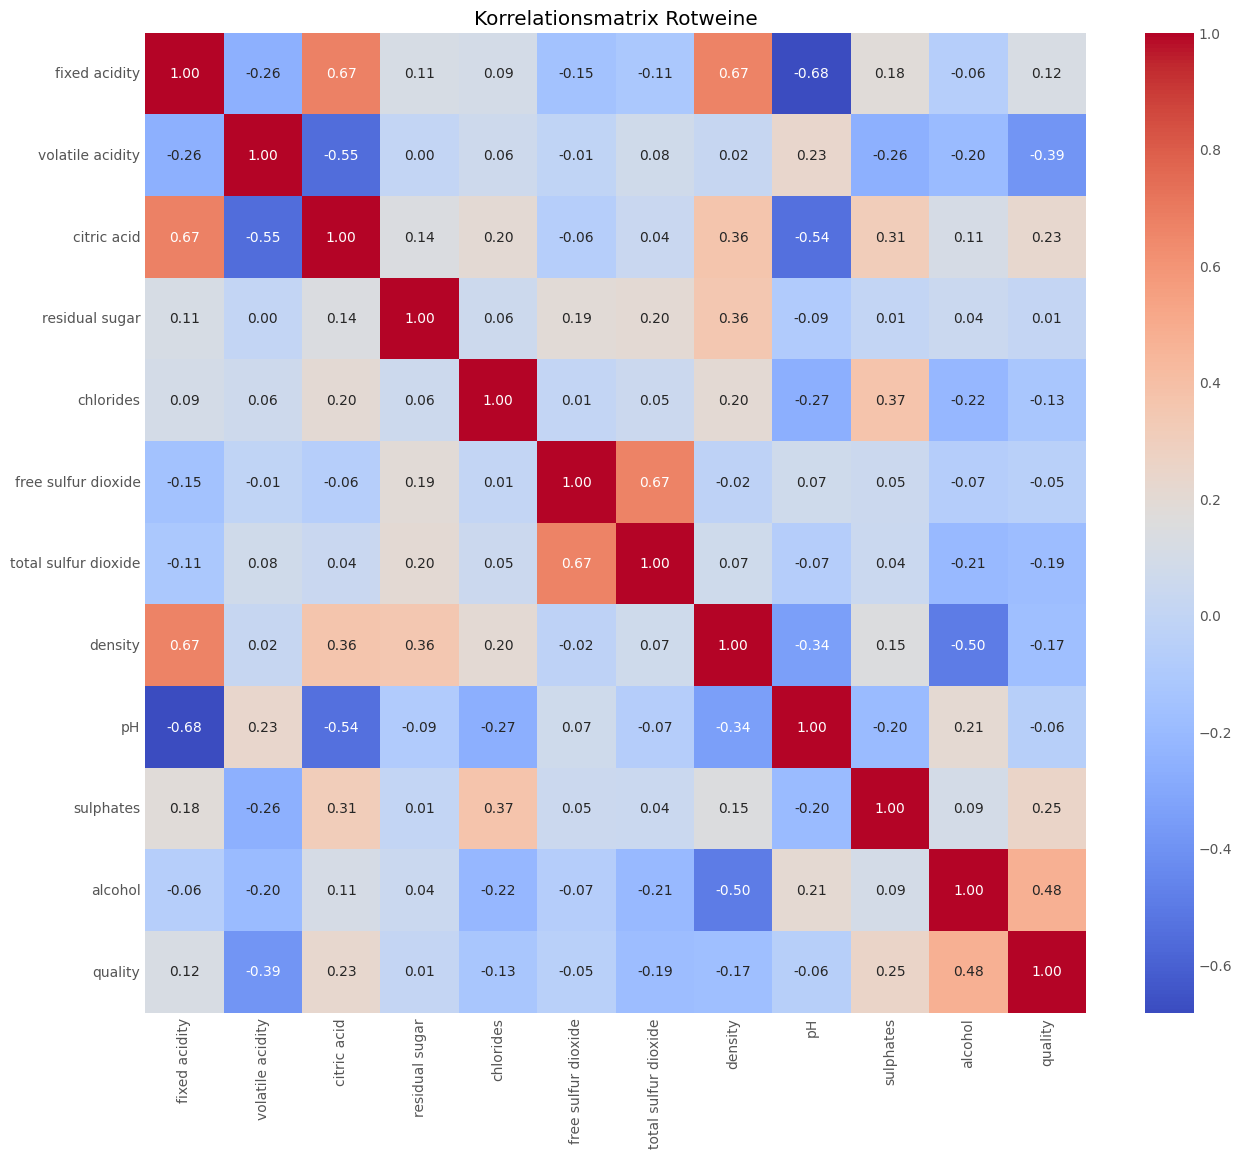

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr('pearson')
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix Rotweine")
plt.show()



- je näher an 1, desto stärker die positive Korrelation  
- je näher an -1, desto stärker die negative Korrelation  
- je näher an 0, desto neutraler die Korrelation  

Frage: Was genau ist positive und negative Korrelation?
Antwort: 
Korrelation = wie sie zueinander stehen bzw reagieren.
If the value rises proportional to the risen value of quality, then it's a positive korrelation.
If the value dropes proportional to the sunken value of quality, then its a negative korrelation.
If they are irrelevant to each other, then its a neutral korrelation.

### Correlation with the feature "quality" (Duc)

In [ ]:
corr_with_quality = corr_matrix["quality"].sort_values(ascending=False)
print(corr_with_quality) #y is also quality


quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


None of the features is neutral to quality.
Ex.: If quality rises by 1, then residual sugar rises by 0.013732
#maybe visualize? histogramm/pairplot  

transformation:
- stretch numbers - smaller ones get bigger and vice versa
Normalisation:
- squash numbers between 0-1 - same scale

-> better for algorithmens to understand

### Distribution of Wine Quality Values (Cathy)

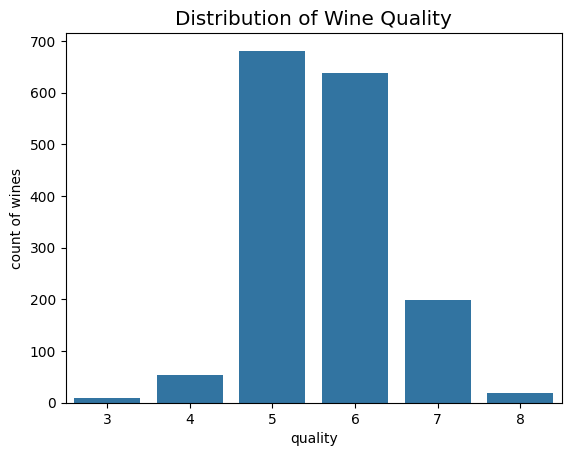

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="quality", data=df)                    #zählt die Einträge in Quality für jeden Wert
plt.style.use("ggplot")
plt.title("Distribution of Wine Quality")
plt.xlabel("quality")
plt.ylabel("count of wines")
plt.show()

plt.style.available  


# 4 Data Model
Define what you want to model (following the table below) and choose an appropriate model framework. Define a simple baseline model and a loss function - theoretically and practically. Explain the model in terms of input-output data structures and dimensions.

# 5 Train Model
Define a Train Define Train and Test Data and run the training loop. Monitor the behaviour of the loss function.

# 6 Evaluate Model
Run model predictions on the test data set. Calculate and visualize the appropriate metrics to evaluate model performance. Explain why a separate test data set should be used for such evaluations.

# 7 Improve Model
Suggest extensions to your baseline model and repeat steps 4. - 6. Do these extensions improve the model?